In [ ]:
%matplotlib inline

# Импорт библиотек

In [ ]:
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Datasets/font_dataset_2size'
print(os.listdir(PATH))
from os import walk
# for (dirpath, dirnames, filenames) in walk(PATH):
#     print("Directory path: ", dirpath)
#     print("Folder name: ", dirnames)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.utils import make_grid
from matplotlib.pyplot import figure

from torchvision import transforms, models
from tqdm import tqdm

Mounted at /content/drive
['train', 'test']


Задание папки с датасетом

In [ ]:
PATH_labels = '/content/drive/MyDrive/Datasets/font_dataset/test'

directory_list = list()
for root, dirs, files in os.walk(PATH_labels, topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(name))

Подготовка загрузчиков и трансформаций для обработки изображений

In [ ]:
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 30

trainset = datasets.ImageFolder(PATH + '/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder(PATH + '/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = sorted(directory_list)

In [ ]:
classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 'К',
 'Л',
 'М',
 'Н',
 'О',
 'П',
 'Р',
 'С',
 'Т',
 'У',
 'Ф',
 'Х',
 'Ц',
 'Ч',
 'Ш',
 'Щ',
 'Ъ',
 'Ы',
 'Ь',
 'Э',
 'Ю',
 'Я']

Отображение элементов датасета

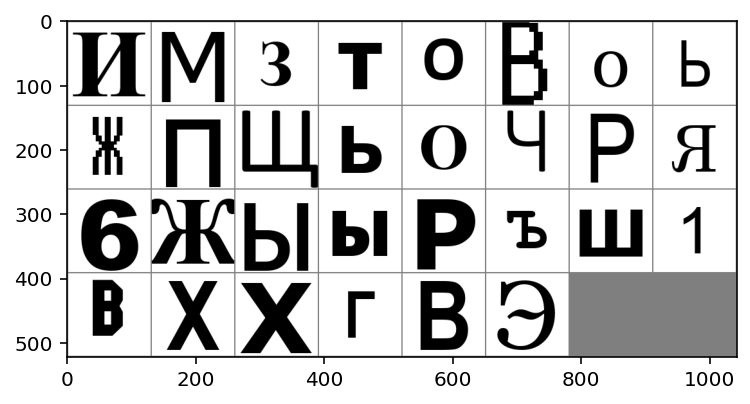

И     М     З     Т     О     В     0     Ь     Ж     П     Щ     Ь     О     Ч     Р     Я     6     Ж     Ы     Ы     Р     Ъ     Ш     1     В     Х     Х     Г     В     Э    


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
images.shape

torch.Size([30, 1, 128, 128])

### 2. Задание параметров нейронной сети
Будем использовать предобученную сеть Resnet18.  
Изменим входной сверточный слой для того, чтобы мы смогли передать изображение с одним каналом.  
Также изменим выходной линейный слой для того, чтобы на выходе было 42 параметра, равному числу классов.




In [ ]:
model = models.resnet18(pretrained=True)

# Отключения градиента для сверточных слоев
for param in model.parameters():
    param.requires_grad = False

model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(model.fc.in_features, 42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = model.to(device)

### 3. Определим функцию потерь и оптимизатор.

Используем кросс-энтропию в качестве функции потерь и оптимизатор Adam с шагом обучения 0.001.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### 4. Обучение сети




In [ ]:
test_loss_history = []
for epoch in range(2000):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    test_loss_history.append(criterion(outputs, labels).data.cpu())
print('Finished Training')

KeyboardInterrupt: ignored

График функции потерь во время обучения

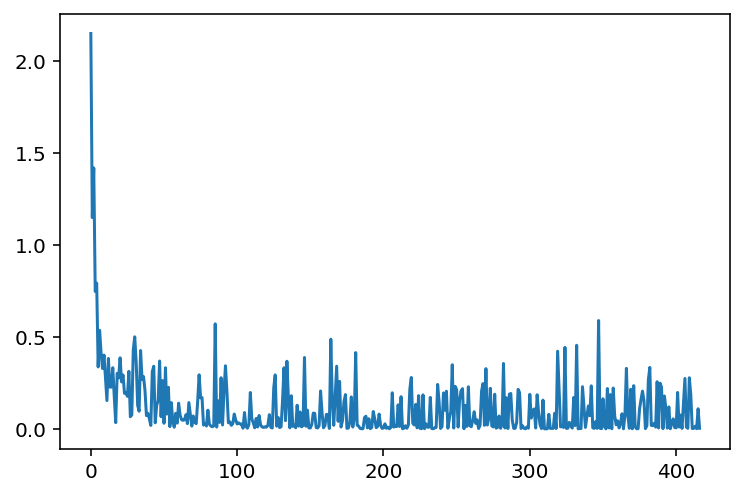

In [ ]:
plt.plot(test_loss_history);

Сохранение весов модели



In [ ]:
PATH = '/content/drive/MyDrive/Datasets/font_net2.pth'
torch.save(net.state_dict(), PATH)

# Получение предсказаний.

Загрузка весов модели

In [ ]:
net = model
net.load_state_dict(torch.load('/content/drive/MyDrive/Datasets/font_net.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

### 5. Проверка на тестовых изображениях

Просмотр тестовых изображений

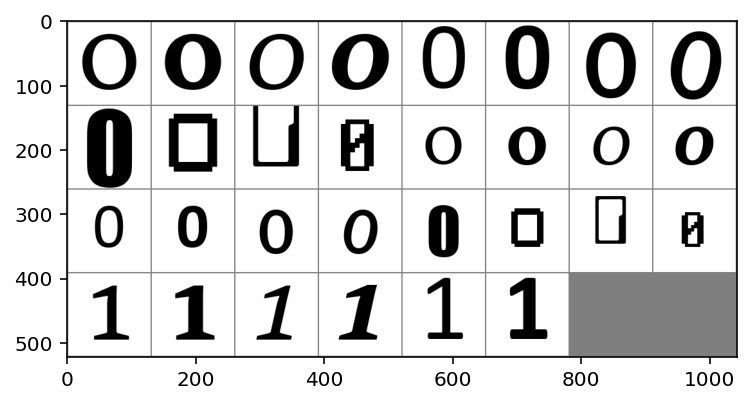

GroundTruth:  0     0     0     0    


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Передадим изображения в сеть и получим предсказание модели.

In [ ]:
images = images.to(device)
outputs = net(images)

In [ ]:
images.shape

torch.Size([30, 1, 128, 128])

In [ ]:
outputs

tensor([[-20.4521, -24.0243, -16.5751,  ..., -17.0381, -10.6853, -16.3340],
        [-14.8508, -25.7618, -26.8543,  ..., -16.6022, -13.6304, -14.0353],
        [-24.5745, -30.4839, -20.8396,  ..., -13.6363, -10.4240, -18.8558],
        ...,
        [-23.3627, -19.5711, -24.7279,  ..., -28.9899, -34.5777, -18.1377],
        [-43.0912,  11.4629, -33.1475,  ..., -29.6121, -29.1010, -22.9971],
        [-38.5469,   2.1344, -24.5390,  ..., -30.8826, -35.3677, -20.9105]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

Перевод тензора из выхода модели в метки классов

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  О     О     О     Э    


Теперь посмотрим на процент верно предсказанных изображений.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 74 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 50.0 %
Accuracy for class: 1     is 79.2 %
Accuracy for class: 2     is 87.5 %
Accuracy for class: 3     is 41.7 %
Accuracy for class: 4     is 79.2 %
Accuracy for class: 5     is 83.3 %
Accuracy for class: 6     is 62.5 %
Accuracy for class: 7     is 87.5 %
Accuracy for class: 8     is 83.3 %
Accuracy for class: 9     is 70.8 %
Accuracy for class: А     is 70.8 %
Accuracy for class: Б     is 79.2 %
Accuracy for class: В     is 75.0 %
Accuracy for class: Г     is 75.0 %
Accuracy for class: Д     is 66.7 %
Accuracy for class: Е     is 83.3 %
Accuracy for class: Ж     is 87.5 %
Accuracy for class: З     is 50.0 %
Accuracy for class: И     is 75.0 %
Accuracy for class: Й    is 79.2 %
Accuracy for class: К     is 79.2 %
Accuracy for class: Л     is 50.0 %
Accuracy for class: М     is 87.5 %
Accuracy for class: Н     is 75.0 %
Accuracy for class: О     is 66.7 %
Accuracy for class: П     is 79.2 %
Accuracy for class: Р     is 91.7 %
Accuracy for class: С     is